### Attention model of cued similarity
- See
    - [perceptual magnet model viz](https://github.com/timsainb/CDCP_paper/blob/01_02_22/notebooks_clean/01_02_22/01_bayesian_model/perceptual-magnet-effect-visualizations.ipynb)
    - [similarity matrix results](https://github.com/timsainb/CDCP_paper/blob/03_17_23/notebooks_clean/01_02_22/10_cued_similarity/analyze-sm-between-cue-and-within.ipynb)
    
- model assumptions
    - We treat the data as having two components for variation
        1. Stimulus-relevant variation
        2. Stimulus irrelevant variation
    - We treat these as two orthogonal dimensions in stimulus space 
    - We treat the noise in perception as being zero-sum: if we attend to one dimension of the signal space, noise in the other dimension will increase
- model description
    - for each prior probability condition
        - for each stimulus
            - compute the likelihood in the stimulus-relevant dimension
            - compute the likelihood in the stimulus irrelevant dimension
            - (in each case as a gaussian modulated by prior)
    - sample *n* points from these distributions
    - compute similarity matrix as average between points for each stimulus relevant bin 
    - compare similarity matrices between cue conditions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

pd.set_option("display.max_columns", 500)
import seaborn as sns
from cdcp.visualization.colors import colors as cdcp_colors
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

%matplotlib inline

In [3]:
from pathlib import Path

In [4]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

/n/groups/datta/tim_sainburg/projects/CDCP_paper/cdcp/general.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load dataframes

In [5]:
from cdcp.paths import DATA_DIR, ensure_dir

In [6]:
prediction_df = pd.read_pickle(DATA_DIR / 'similarity_shift_model' / 'prediction_df.pickle')

In [7]:
prob_df = pd.read_pickle(DATA_DIR / 'similarity_shift_model' / 'prob_df.pickle')

In [8]:
# which columns are cue valid
prediction_df['left_stim'] = prediction_df.true_x < 100
prediction_df['cue_valid'] = (prediction_df.left_stim & (prediction_df.p_left > 0.5)) | ((prediction_df.left_stim == False) & (prediction_df.p_left < 0.5))
prediction_df['cue_invalid'] = (prediction_df.left_stim & (prediction_df.p_left < 0.5)) | ((prediction_df.left_stim == False) & (prediction_df.p_left > 0.5))
prediction_df['cued'] = prediction_df['cue_valid'] | prediction_df['cue_invalid']

In [9]:
prediction_df['cue_left'] = prediction_df['p_left'] > 0.5
prediction_df['cue_right'] = prediction_df['p_left'] <0.5

In [10]:
# we only care about cued data
prediction_df = prediction_df[prediction_df.cued]

### Parameters

In [11]:
probability_left_ranges = [0.125, 0.25, 0.5, 0.75, 0.875]
sigma_likelihood = 5
sigma_likelihood_irrelevant = 3

In [12]:
# decision 
x_true = np.arange(-100, 100)
half = int(len(x_true) / 2)
decision_boundary = np.concatenate([np.zeros(half), np.ones(half)])
bds = [half - 64, half + 64]
x_true_bds = [x_true[half] - 64, x_true[half] + 64]

n_samples_per_x_true = 200
irrelevant_multiplier = 5
n_repeats_posterior = 100 # 
n_repeats_likelihood = 1

In [13]:
# the 
point_indices = np.arange(len(x_true))

In [14]:
prediction_df = prediction_df[(prediction_df.true_x >= bds[0]) & (prediction_df.true_x < bds[1])]

### Decoder model on likelihood

#### Predict interpolation point

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [16]:
# subset into train and test
test_subset_prop = 0.5
X_likelihood = np.stack(prediction_df.response_likelihood)
y = prediction_df.true_x.values.astype(int)
X_likelihood.shape
indices = np.arange(len(X_likelihood))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_likelihood, y, indices, test_size=0.5, random_state=42
)

# add train test split to predictions_df
test_cols = np.zeros(len(prediction_df), dtype=bool)
test_cols[indices_test] = True
prediction_df["test"] = test_cols

In [17]:
prediction_df[:3]

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False


In [18]:
bds

[36, 164]

In [19]:
# data are equally distributed
print(
    np.mean(prediction_df.cue_valid & prediction_df.left_stim),
    np.mean((prediction_df.cue_valid == False) & (prediction_df.left_stim == False)),
    np.mean(prediction_df.cue_valid & prediction_df.left_stim),
    np.mean((prediction_df.cue_valid == False) & (prediction_df.left_stim == False))
)

0.25 0.25 0.25 0.25


In [20]:
# use logistic regression
use_logistic_regression = False
if use_logistic_regression:
    # Create an instance of the logistic regression classifier
    clf = linear_model.LogisticRegression(
        penalty="l2", class_weight="balanced", tol=0.01, n_jobs=15, solver="sag", 
    )

    # fit model
    clf.fit(X_train, y_train)

    # get predictions for all data
    predictions = clf.predict(np.stack(prediction_df.response_likelihood))

    # add to model
    prediction_df["likelihood_predictions"] = predictions
    
else:
    # add to model
    prediction_df["likelihood_predictions"] = np.stack(prediction_df.response_likelihood)[:,0]

# add the error
prediction_df["likelihood_predictions_correct"] = (
    prediction_df["likelihood_predictions"] == prediction_df["true_x"]
)
prediction_df["likelihood_predictions_error"] = np.abs(
    prediction_df["likelihood_predictions"] - prediction_df["true_x"]
)

In [21]:
prediction_df[:3]

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4


In [22]:
print(
    prediction_df.likelihood_predictions_correct.mean(),
    prediction_df.likelihood_predictions_error.mean(),
)

0.07896484375 6.9197265625


In [23]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_valid'])['likelihood_predictions_error'].mean().reset_index()

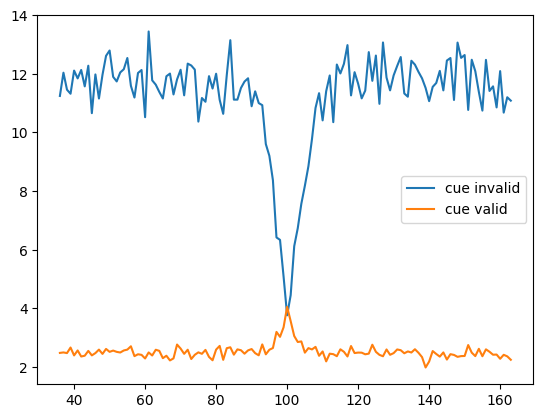

In [24]:
m = grouped_data.cue_valid == False
plt.plot(
    grouped_data[m].true_x.values, grouped_data[m].likelihood_predictions_error.values,
    label = 'cue invalid'
)
plt.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].likelihood_predictions_error.values,
    label = 'cue valid'
)
plt.legend()

In [25]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_valid'])['likelihood_predictions'].mean().reset_index()

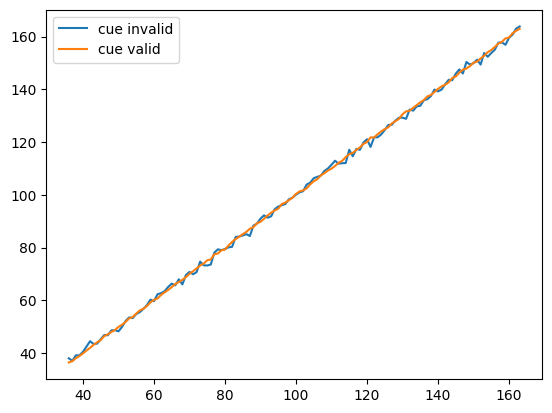

In [26]:
m = grouped_data.cue_valid == False
plt.plot(
    grouped_data[m].true_x.values, grouped_data[m].likelihood_predictions.values,
    label = 'cue invalid'
)
plt.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].likelihood_predictions.values,
    label = 'cue valid'
)
plt.legend()

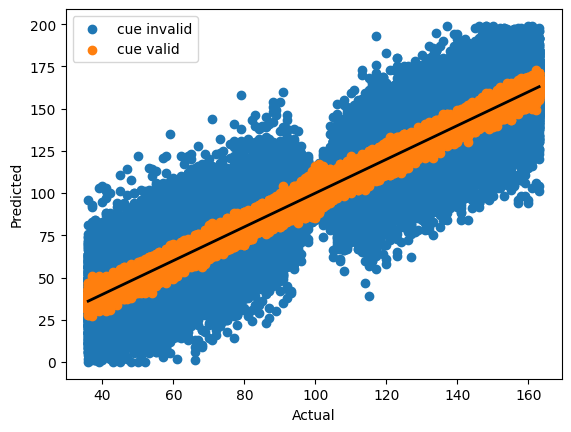

In [27]:
fig, ax = plt.subplots()
m = prediction_df.cue_valid == False

ax.scatter(
    prediction_df[m].true_x.values, 
    prediction_df[m].likelihood_predictions.values,
    label = 'cue invalid'
)
ax.scatter(
    prediction_df[m == False].true_x.values,
    prediction_df[m == False].likelihood_predictions.values,
    label = 'cue valid'
)

min_x = np.min(prediction_df.true_x.values)
max_x = np.max(prediction_df.true_x.values)
ax.plot([min_x, max_x], [min_x, max_x], color = 'k', lw=2)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.legend()

In [28]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_left'])['likelihood_predictions'].mean().reset_index()
grouped_data['true_side'] = grouped_data['true_x'] > 100

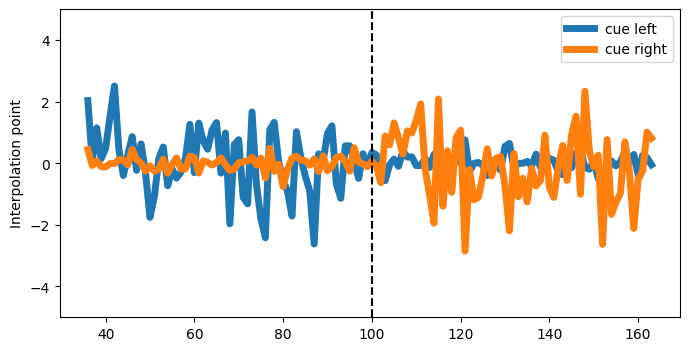

In [29]:
fig, ax = plt.subplots(figsize=(8,4))
m = grouped_data.cue_left == False
ax.plot(
    grouped_data[m].true_x.values,
    grouped_data[m].likelihood_predictions.values - grouped_data[m]['true_x'].values, 
    label = 'cue left',
    lw=5
)
ax.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].likelihood_predictions.values - grouped_data[m == False]['true_x'].values, 
    label = 'cue right',
    lw=5
)
ax.set_ylim([-5,5])
ax.axvline(100, ls = 'dashed', color = 'k')
ax.set_ylabel('Prediction - True')
ax.set_ylabel('Interpolation point')
plt.legend()

#### predict side

In [30]:
# subset into train and test
X_likelihood = np.stack(prediction_df.response_likelihood)
y = prediction_df.true_x.values.astype(int) < 100

X_train = X_likelihood[indices]
y_train = y[indices]

In [31]:
# use logistic regression
if use_logistic_regression:
    # Create an instance of the logistic regression classifier
    clf = linear_model.LogisticRegression(
        penalty="l2", class_weight="balanced", tol=0.01, n_jobs=10, solver="sag", 
    )

    # fit model
    clf.fit(X_train, y_train)

    # get predictions for all data
    predictions = clf.predict(np.stack(prediction_df.response_likelihood))

    # add to model
    prediction_df["likelihood_side_predictions"] = predictions
else:
    prediction_df["likelihood_side_predictions"] = np.stack(prediction_df.response_likelihood)[:,0] < 100
    
prediction_df['likelihood_side_correct'] = prediction_df.likelihood_side_predictions == prediction_df.left_stim

In [32]:
prediction_df

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error,likelihood_side_predictions,likelihood_side_correct
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15,True,True
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4,True,True
7203,0.125,36,"[58, 495, 505]",26,True,False,True,True,False,True,False,58,False,22,True,True
7204,0.125,36,"[26, 495, 500]",36,True,False,True,True,False,True,True,26,False,10,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32795,0.75,163,"[163, 495, 510]",162,False,False,True,True,True,False,False,163,True,0,False,True
32796,0.75,163,"[166, 500, 495]",160,False,False,True,True,True,False,True,166,False,3,False,True
32797,0.75,163,"[153, 490, 485]",163,False,False,True,True,True,False,False,153,False,10,False,True
32798,0.75,163,"[162, 515, 490]",170,False,False,True,True,True,False,False,162,False,1,False,True


In [33]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].likelihood_side_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].likelihood_side_correct)
)

0.977734375 0.91212890625


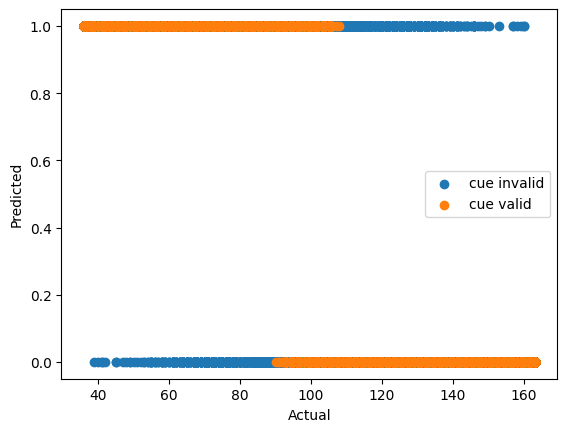

In [34]:
fig, ax = plt.subplots()
m = prediction_df.cue_valid == False

ax.scatter(
    prediction_df[m].true_x.values, 
    prediction_df[m].likelihood_side_predictions.values,
    label = 'cue invalid'
)
ax.scatter(
    prediction_df[m == False].true_x.values,
    prediction_df[m == False].likelihood_side_predictions.values,
    label = 'cue valid'
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.legend()

### Decoder model on posterior

#### predict interpolation point

In [35]:
prediction_df

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error,likelihood_side_predictions,likelihood_side_correct
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15,True,True
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4,True,True
7203,0.125,36,"[58, 495, 505]",26,True,False,True,True,False,True,False,58,False,22,True,True
7204,0.125,36,"[26, 495, 500]",36,True,False,True,True,False,True,True,26,False,10,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32795,0.75,163,"[163, 495, 510]",162,False,False,True,True,True,False,False,163,True,0,False,True
32796,0.75,163,"[166, 500, 495]",160,False,False,True,True,True,False,True,166,False,3,False,True
32797,0.75,163,"[153, 490, 485]",163,False,False,True,True,True,False,False,153,False,10,False,True
32798,0.75,163,"[162, 515, 490]",170,False,False,True,True,True,False,False,162,False,1,False,True


In [36]:
# subset into train and test
X_posterior = np.stack(prediction_df.response_posterior)
y = prediction_df.true_x.values.astype(int)

X_train = X_posterior[indices]
y_train = y[indices]

In [37]:
# use logistic regression
if use_logistic_regression:
    # Create an instance of the logistic regression classifier
    clf = linear_model.LogisticRegression(
        penalty="l2", class_weight="balanced", tol=0.01, n_jobs=15, solver="sag", 
    )

    # fit model
    clf.fit(X_train, y_train)

    # get predictions for all data
    predictions = clf.predict(np.stack(prediction_df.response_likelihood))

    # add to model
    prediction_df["posterior_predictions"] = predictions
    
else:
    # add to model
    prediction_df["posterior_predictions"] = np.stack(prediction_df.response_posterior)

# add the error
prediction_df["posterior_predictions_correct"] = (
    prediction_df["posterior_predictions"] == prediction_df["true_x"]
)
prediction_df["posterior_predictions_error"] = np.abs(
    prediction_df["posterior_predictions"] - prediction_df["true_x"]
)

In [38]:
print(
    prediction_df.posterior_predictions_correct.mean(),
    prediction_df.posterior_predictions_error.mean(),
)

0.078037109375 4.01732421875


In [39]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_valid'])['posterior_predictions_error'].mean().reset_index()

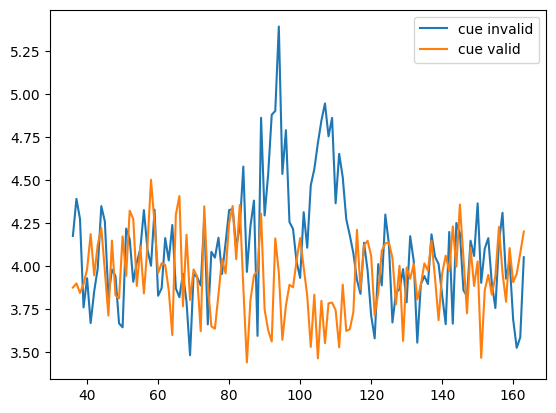

In [40]:
m = grouped_data.cue_valid == False
plt.plot(
    grouped_data[m].true_x.values, grouped_data[m].posterior_predictions_error.values,
    label = 'cue invalid'
)
plt.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].posterior_predictions_error.values,
    label = 'cue valid'
)
plt.legend()

In [41]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_valid'])['posterior_predictions'].mean().reset_index()

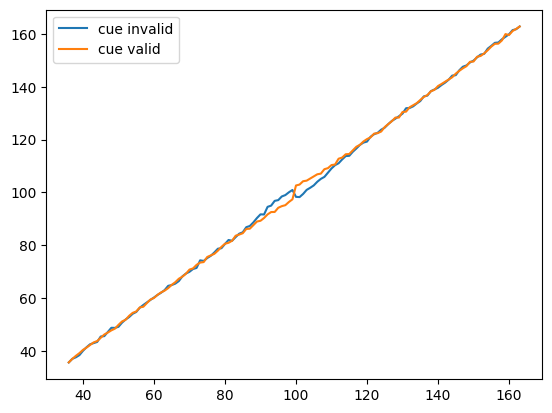

In [42]:
m = grouped_data.cue_valid == False
plt.plot(
    grouped_data[m].true_x.values, grouped_data[m].posterior_predictions.values,
    label = 'cue invalid'
)
plt.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].posterior_predictions.values,
    label = 'cue valid'
)
plt.legend()

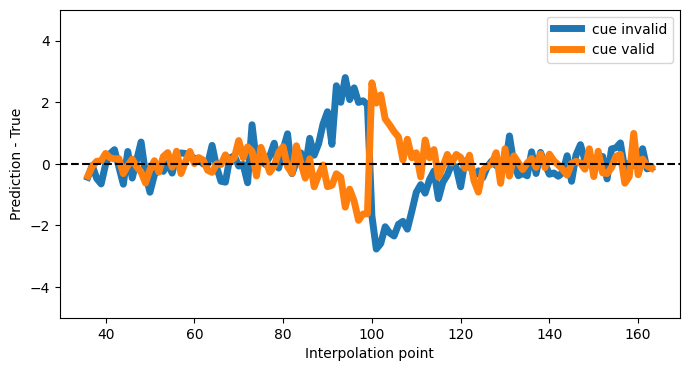

In [43]:
fig, ax = plt.subplots(figsize=(8,4))
m = grouped_data.cue_valid == False
ax.plot(
    grouped_data[m].true_x.values, grouped_data[m].posterior_predictions.values - grouped_data[m].true_x.values,
    label = 'cue invalid',
    lw=5
)
ax.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].posterior_predictions.values - grouped_data[m].true_x.values,
    label = 'cue valid',
    lw=5
)
ax.set_ylabel('Prediction - True')
ax.set_xlabel('Interpolation point')
ax.set_ylim([-5,5])
ax.axhline(0, color = 'k', ls = 'dashed')
plt.legend()

In [44]:
prediction_df['posterior_predicted_side'] = prediction_df['posterior_predictions'] > 100

In [45]:
# subset only the test data
test_data = prediction_df[(prediction_df['test']) & (prediction_df['cued'])]
grouped_data = test_data.groupby(['true_x', 'cue_left'])['posterior_predictions'].mean().reset_index()
grouped_data['true_side'] = grouped_data['true_x'] > 100

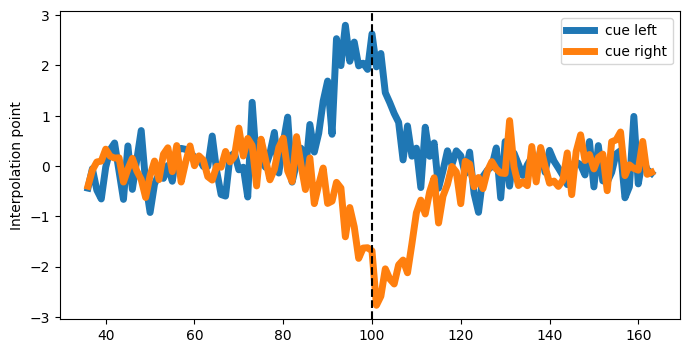

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
m = grouped_data.cue_left == False
ax.plot(
    grouped_data[m].true_x.values,
    grouped_data[m].posterior_predictions.values - grouped_data[m]['true_x'].values, 
    label = 'cue left',
    lw=5
)
ax.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].posterior_predictions.values - grouped_data[m == False]['true_x'].values, 
    label = 'cue right',
    lw=5
)
ax.axvline(100, ls = 'dashed', color = 'k')
ax.set_ylabel('Prediction - True')
ax.set_ylabel('Interpolation point')
plt.legend()

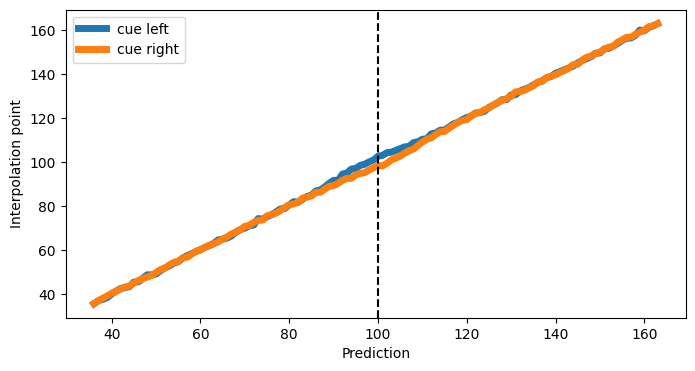

In [47]:
fig, ax = plt.subplots(figsize=(8,4))
m = grouped_data.cue_left == False
ax.plot(
    grouped_data[m].true_x.values,
    grouped_data[m].posterior_predictions.values, 
    label = 'cue left',
    lw=5
)
ax.plot(
    grouped_data[m == False].true_x.values,
    grouped_data[m == False].posterior_predictions.values, 
    label = 'cue right',
    lw=5
)
ax.axvline(100, ls = 'dashed', color = 'k')
ax.set_xlabel('Prediction')
ax.set_ylabel('Interpolation point')
plt.legend()

Text(0, 0.5, 'Interpolation point')

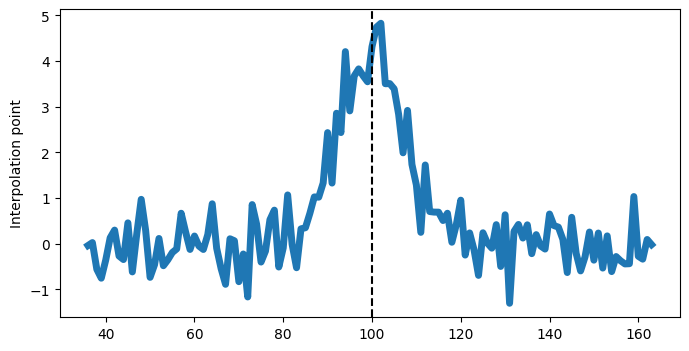

In [48]:
fig, ax = plt.subplots(figsize=(8,4))
m = grouped_data.cue_left == False
ax.plot(
    grouped_data[m].true_x.values,
    grouped_data[m].posterior_predictions.values - grouped_data[m == False].posterior_predictions.values ,
    lw=5
)
ax.axvline(100, ls = 'dashed', color = 'k')
ax.set_ylabel('Prediction - True')
ax.set_ylabel('Interpolation point')


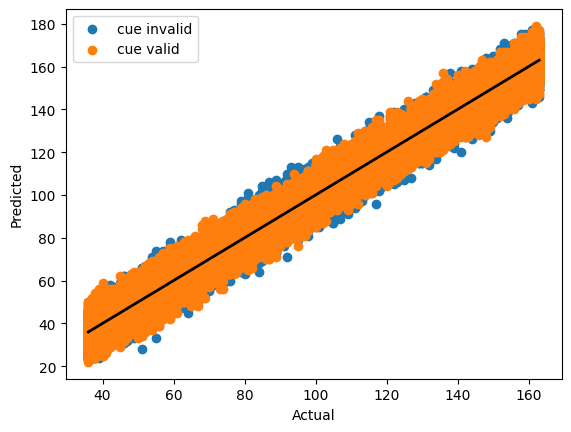

In [49]:
fig, ax = plt.subplots()
m = prediction_df.cue_valid == False

ax.scatter(
    prediction_df[m].true_x.values, 
    prediction_df[m].posterior_predictions.values,
    label = 'cue invalid'
)
ax.scatter(
    prediction_df[m == False].true_x.values,
    prediction_df[m == False].posterior_predictions.values,
    label = 'cue valid'
)

min_x = np.min(prediction_df.true_x.values)
max_x = np.max(prediction_df.true_x.values)
ax.plot([min_x, max_x], [min_x, max_x], color = 'k', lw=2)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.legend()

In [50]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].posterior_predictions_error), 
    np.mean(prediction_df[prediction_df.cue_invalid].posterior_predictions_error)
)

3.93041015625 4.10423828125


#### Predict side

In [51]:
# subset into train and test
X_posterior = np.stack(prediction_df.response_posterior)
y = prediction_df.true_x.values.astype(int) < 100

X_train = X_posterior[indices]
y_train = y[indices]

In [52]:
# use logistic regression
if use_logistic_regression:
    # Create an instance of the logistic regression classifier
    clf = linear_model.LogisticRegression(
        penalty="l2", class_weight="balanced", tol=0.01, n_jobs=10, solver="sag", 
    )

    # fit model
    clf.fit(X_train, y_train)

    # get predictions for all data
    predictions = clf.predict(np.stack(prediction_df.response_likelihood))

    # add to model
    prediction_df["posterior_side_predictions"] = predictions
else:
    prediction_df["posterior_side_predictions"] = np.stack(prediction_df.response_posterior) < 100
    
prediction_df['posterior_side_correct'] = prediction_df.posterior_side_predictions == prediction_df.left_stim

In [53]:
prediction_df

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error,likelihood_side_predictions,likelihood_side_correct,posterior_predictions,posterior_predictions_correct,posterior_predictions_error,posterior_predicted_side,posterior_side_predictions,posterior_side_correct
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15,True,True,33,False,3,False,True,True
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3,True,True,28,False,8,False,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4,True,True,40,False,4,False,True,True
7203,0.125,36,"[58, 495, 505]",26,True,False,True,True,False,True,False,58,False,22,True,True,26,False,10,False,True,True
7204,0.125,36,"[26, 495, 500]",36,True,False,True,True,False,True,True,26,False,10,True,True,36,True,0,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32795,0.75,163,"[163, 495, 510]",162,False,False,True,True,True,False,False,163,True,0,False,True,162,False,1,True,False,True
32796,0.75,163,"[166, 500, 495]",160,False,False,True,True,True,False,True,166,False,3,False,True,160,False,3,True,False,True
32797,0.75,163,"[153, 490, 485]",163,False,False,True,True,True,False,False,153,False,10,False,True,163,True,0,True,False,True
32798,0.75,163,"[162, 515, 490]",170,False,False,True,True,True,False,False,162,False,1,False,True,170,False,7,True,False,True


In [54]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].posterior_side_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].posterior_side_correct)
)

0.98291015625 0.943828125


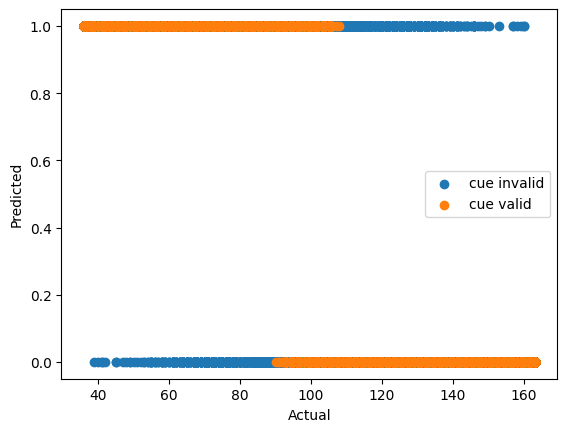

In [55]:
fig, ax = plt.subplots()
m = prediction_df.cue_valid == False

ax.scatter(
    prediction_df[m].true_x.values, 
    prediction_df[m].likelihood_side_predictions.values,
    label = 'cue invalid'
)
ax.scatter(
    prediction_df[m == False].true_x.values,
    prediction_df[m == False].likelihood_side_predictions.values,
    label = 'cue valid'
)

ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.legend()

### Plot results

In [56]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].likelihood_predictions_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].likelihood_predictions_correct)
)

0.12646484375 0.03146484375


In [57]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].likelihood_side_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].likelihood_side_correct)
)

0.977734375 0.91212890625


In [58]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].posterior_predictions_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].posterior_predictions_correct)
)

0.07927734375 0.076796875


In [59]:
print(
    np.mean(prediction_df[prediction_df.cue_valid].posterior_side_correct), 
    np.mean(prediction_df[prediction_df.cue_invalid].posterior_side_correct)
)

0.98291015625 0.943828125


In [60]:
results_dict = {
    
        "Lik. morph":(
            np.mean(
                prediction_df[prediction_df.cue_valid].likelihood_predictions_correct
            )
            - np.mean(
                prediction_df[prediction_df.cue_invalid].likelihood_predictions_correct
            )
        ),
        "Lik. cat":(
            np.mean(prediction_df[prediction_df.cue_valid].likelihood_side_correct)
            - np.mean(prediction_df[prediction_df.cue_invalid].likelihood_side_correct)
        ),
        "Post. morph":(
            np.mean(
                prediction_df[prediction_df.cue_valid].posterior_predictions_correct
            )
            - np.mean(
                prediction_df[prediction_df.cue_invalid].posterior_predictions_correct
            )
        ),
        "Post. cat":(
            np.mean(prediction_df[prediction_df.cue_valid].posterior_side_correct)
            - np.mean(prediction_df[prediction_df.cue_invalid].posterior_side_correct)
        ),
}

In [61]:
results_dict.keys()

dict_keys(['Lik. morph', 'Lik. cat', 'Post. morph', 'Post. cat'])

<BarContainer object of 4 artists>

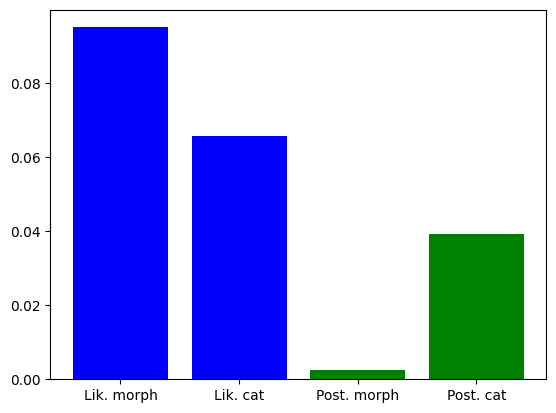

In [62]:
plt.bar(
    results_dict.keys(),
    list(results_dict.values()),
    color = ['blue', 'blue', 'green', 'green']
)

In [63]:
list(results_dict.values())

[0.095, 0.06560546875000006, 0.002480468750000006, 0.03908203124999998]

### Prediction by distance

In [64]:
prediction_df[:3]

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error,likelihood_side_predictions,likelihood_side_correct,posterior_predictions,posterior_predictions_correct,posterior_predictions_error,posterior_predicted_side,posterior_side_predictions,posterior_side_correct
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15,True,True,33,False,3,False,True,True
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3,True,True,28,False,8,False,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4,True,True,40,False,4,False,True,True


In [65]:
x_true = prediction_df[prediction_df.cue_valid == True].true_x.values
x_predicted = prediction_df[prediction_df.cue_valid == True].likelihood_predictions.values
acc_curve_valid = np.array(
    [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 128)]
)
acc_curve_sem_valid = np.array(
    [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 128)]
)
x_true = prediction_df[prediction_df.cue_valid == False].true_x.values
x_predicted = prediction_df[prediction_df.cue_valid == False].likelihood_predictions.values
acc_curve_invalid = np.array(
    [np.mean(np.abs(x_true - x_predicted) < i) for i in range(1, 128)]
)
acc_curve_sem_invalid = np.array(
    [np.std(np.abs(x_true - x_predicted) < i)/np.sqrt(len(x_true)) for i in range(1, 17)]
)

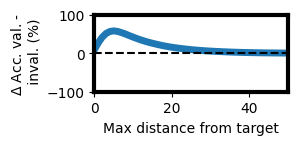

In [80]:
fig, ax = plt.subplots(figsize=(2.5,1))
ax.plot((acc_curve_valid - acc_curve_invalid)*100, lw=5)
m = (acc_curve_valid - acc_curve_invalid)*100
err = acc_curve_sem_valid * 100
ax.fill_between(np.arange(len(m)), m-err, m+err, color = 'blue', alpha = 0.25)
ax.axhline(0, color = 'k', ls='dashed')
#ax.set_ylim([-2,2])\
ax.set_ylim([-100, 100])
ax.set_xlim([0,50])
ax.set_ylabel('$\Delta$ Acc. val. - \n inval. (%)')
ax.set_xlabel('Max distance from target')
[i.set_linewidth(3) for i in ax.spines.values()]

if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'population_decoder' )
    save_fig(FIGURE_DIR / 'population_decoder'/ 'cued-acc-improvement-model', save_pdf=True)
    plt.show()

### Neurometric decoder

In [67]:
prediction_df[:3]

,p_left,true_x,response_likelihood,response_posterior,left_stim,cue_valid,cue_invalid,cued,cue_left,cue_right,test,likelihood_predictions,likelihood_predictions_correct,likelihood_predictions_error,likelihood_side_predictions,likelihood_side_correct,posterior_predictions,posterior_predictions_correct,posterior_predictions_error,posterior_predicted_side,posterior_side_predictions,posterior_side_correct
7200,0.125,36,"[51, 500, 500]",33,True,False,True,True,False,True,False,51,False,15,True,True,33,False,3,False,True,True
7201,0.125,36,"[33, 500, 505]",28,True,False,True,True,False,True,True,33,False,3,True,True,28,False,8,False,True,True
7202,0.125,36,"[32, 500, 500]",40,True,False,True,True,False,True,False,32,False,4,True,True,40,False,4,False,True,True


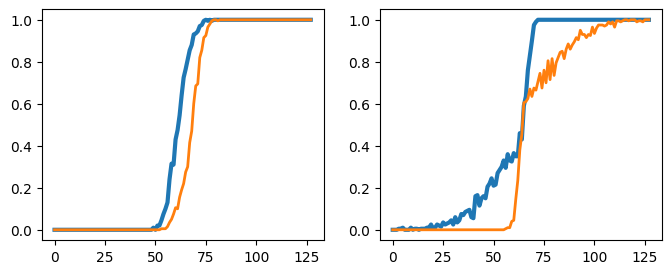

In [68]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
predictions_right = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.125) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
predictions_left = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.875) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
axs[0].plot(
    predictions_right, lw=3
)
axs[0].plot(
    predictions_left, lw=2
)

# likelihood
predictions_right = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.125) & (prediction_df["true_x"] == i)
            ].likelihood_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
predictions_left = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.875) & (prediction_df["true_x"] == i)
            ].likelihood_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
axs[1].plot(
    predictions_right, lw=3
)
axs[1].plot(
    predictions_left, lw=2
)

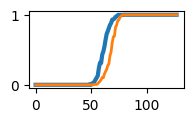

In [69]:
fig, axs = plt.subplots(ncols=1, figsize=(2, 1))
predictions_right = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.125) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
predictions_left = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.875) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in prediction_df.true_x.unique()
    ]
axs.plot(
    predictions_right, lw=3
)
axs.plot(
    predictions_left, lw=2
)

In [70]:
from cdcp.visualization.colors import colors as cdcp_colors

In [71]:
x = prediction_df.true_x.unique()
predictions_right = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.125) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in x
    ]
predictions_left = [
        np.mean(
            prediction_df[
                (prediction_df["p_left"] == 0.875) & (prediction_df["true_x"] == i)
            ].posterior_predictions.values
            > 100
        )
        for i in x
    ]
x = x - 36
x = x.astype(np.float32)

In [72]:
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic

In [74]:
SAVE_FIGS = True

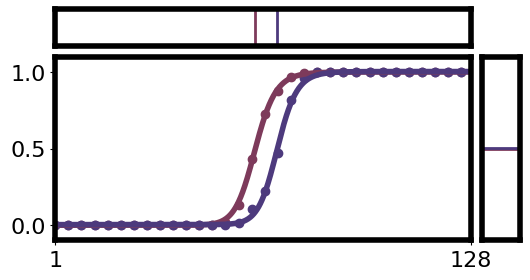

In [81]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(6, 3),
    gridspec_kw={
        "height_ratios": [1, 5],
        "width_ratios": [11, 1],
        "hspace": 0.1,
        "wspace": 0.05,
    },
)
ax = axs[0, 0]
ax.set_xticks([], [])
ax.set_yticks([])
plt.tick_params(axis="both", which="major", labelsize=16)
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_xlim([0, 127])

ax = axs[0, 1]
ax.axis("off")

ax = axs[1, 0]

# cue right
ax.scatter(x[::4], predictions_right[::4], color=cdcp_colors["cue"]["R"]["dark"])

# fit logistic
(
    (_min, _max, _inflection, _slope),
    results_logistic_CR,
    y_model,
    r_squared,
) = fit_FourParameterLogistic(
    x,
    predictions_right,
    _inflection=(128 / 2) - 1,
    _inflection_bounds=[
        0 + int(128 / 8),
        128 - 1 - int(128 / 8),
    ],
    _min_bounds=[-1, 2],
    _max_bounds=[-1, 2],
)
xmodel = np.linspace(0,128, 1000)
ymodel = FourParameterLogistic({"_min":_min, "_max":_max, "inflection":_inflection, "slope":_slope}, xmodel)

ax.plot(
    xmodel, ymodel, color=cdcp_colors["cue"]["R"]["dark"], lw=4,
)
axs[0, 0].axvline(_inflection, color=cdcp_colors["cue"]["R"]["dark"], lw=2)

midpoint_csr = (_min+(_max - _min) / 2)
axs[1, 1].axhline(
    midpoint_csr, color=cdcp_colors["cue"]["R"]["dark"], lw =2
)

# cue left
ax.scatter(x[::4], predictions_left[::4], color=cdcp_colors["cue"]["L"]["dark"])
# fit logistic
(
    (_min, _max, _inflection, _slope),
    results_logistic_CL,
    y_model,
    r_squared,
) = fit_FourParameterLogistic(
    x,
    predictions_left,
    _inflection=(128 / 2) - 1,
    _inflection_bounds=[
        0 + int(128 / 8),
        128 - 1 - int(128 / 8),
    ],
    _min_bounds=[-1, 2],
    _max_bounds=[-1, 2],
)
xmodel = np.linspace(0,128, 1000)
ymodel = FourParameterLogistic({"_min":_min, "_max":_max, "inflection":_inflection, "slope":_slope}, xmodel)

ax.plot(
    xmodel, ymodel, color=cdcp_colors["cue"]["L"]["dark"], lw=4,
)

axs[0, 0].axvline(_inflection, color=cdcp_colors["cue"]["L"]["dark"], lw=2)

midpoint_csr = (_min+(_max - _min) / 2)
axs[1, 1].axhline(
    midpoint_csr, color=cdcp_colors["cue"]["L"]["dark"], lw =2
)

if False:
    ax.errorbar(
        x,
        cue_right_nm,
        yerr=cue_right_nm_sem * 3,
        alpha=1,
        ls='none',
        color=cdcp_colors["cue"]["R"]["dark"],
    )
    ax.errorbar(
        x,
        cue_left_nm,
        yerr=cue_left_nm_sem * 3,
        alpha=1,
        ls='none',
         color=cdcp_colors["cue"]["L"]["dark"]
    )
ax.set_ylim([0, 1])

ax.set_xticks([0,127])
#ax.set_yticks([0,1])
ax.set_xticklabels([1,128])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([0, 127])
[i.set_linewidth(4) for i in ax.spines.values()];

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)


ax = axs[1, 1]
ax.set_ylim(axs[1,0].get_ylim())

ax = axs[1, 1]
ax.set_xticks([])
ax.set_yticks([])
[i.set_linewidth(4) for i in ax.spines.values()]
ax.set_ylim([0, 1])


if SAVE_FIGS:
    ensure_dir(FIGURE_DIR / 'population_decoder' )
    save_fig(FIGURE_DIR / 'population_decoder'/ 'neurometric-shift-model', save_pdf=True)
    plt.show()
